In [38]:
import numpy as np
import dlib
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

(168, 299, 3)


In [59]:
def detect_face_opencv(img):
    face_cascade = cv2.CascadeClassifier('artifacts/opencv_frontal_face.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    return faces

In [60]:
dets = detect_face_opencv(image)
print(dets)
(x, y, w,h) = dets[0]
# cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

[[ 97  25  89  89]
 [152   1  53  53]]


In [251]:
image = cv2.imread('data/with_mask/78-with-mask.jpg')      
print(image.shape)
detector = dlib.get_frontal_face_detector()
dets = detector(image, 1)
if list(dets) == []:
    dets = detect_face_opencv(image)
    for d in dets:
        print(d)
        x = d[0] + d[2]//2
        y = d[1] + d[3]//2
        w = d[2]
        h = d[3]
else:
    for d in dets:
        print(d)
        x = d.left() + (d.right() - d.left())//2
        y = d.top() + (d.bottom() - d.top())//2
        w = d.right() - d.left()
        h = d.bottom() - d.top()

# cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
print(image.shape)

(168, 299, 3)
[152   1  53  53]
[97 25 89 89]
(168, 299, 3)


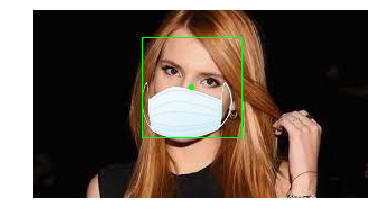

In [135]:
cv2.circle(image, (x, y),1,(0,255,0),2)
# cv2.circle(image, (w, h),1,(0,0,255),2)
# cv2.line(image, (0, 0), (x, 0), (0, 255, 0),2)
# cv2.line(image, (0, 0), (0, y), (0, 255, 0),2)
cv2.rectangle(image, (x-(w//2), y-(h//2)), ((x-(w//2)) + w, (y-(h//2)) + h), (0, 255, 0), 1)
# cv2.rectangle(image, ((2*x - w)//3, (2*y - h)//3), (), (0, 255, 0), 2)
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [148]:
def transform_annotation(x):
    """Convert the annotation/target boxes to a format understood by
    dataset class"""
    #convert the PIL image to a numpy array
    if not x:
        return None
    boxes = np.array([a.rstrip().split(' ') for a in x], dtype='float32')
    print(boxes)
    
    #get the bounding boxes and convert them into proper format
    box = boxes[:, 1:]
    print(box)
    box = np.array(box)
    box = box.reshape(-1,4)
    print(box)
    
    category_ids = np.array(boxes[:,0]).reshape(-1,1)
    print(category_ids)
    ground_truth = np.concatenate([box, category_ids], 1).reshape(-1,5)
  
    return ground_truth

In [149]:
transform_annotation(['{} {} {} {} {}'.format(1,x,y,w,h)])

[[  1. 141.  69.  89.  89.]]
[[141.  69.  89.  89.]]
[[141.  69.  89.  89.]]
[[1.]]


array([[141.,  69.,  89.,  89.,   1.]], dtype=float32)

In [206]:
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding
    
    Parameters
    ----------
    
    img : numpy.ndarray
        Image 
    
    inp_dim: tuple(int)
        shape of the reszied image
        
    Returns
    -------
    
    numpy.ndarray:
        Resized image
    
    '''

    inp_dim = (inp_dim, inp_dim)
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h))
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 0)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

class YoloResize(object):
    """Resize the image in accordance to `image_letter_box` function in darknet 
    
    The aspect ratio is maintained. The longer side is resized to the input 
    size of the network, while the remaining space on the shorter side is filled 
    with black color. **This should be the last transform**
    
    
    Parameters
    ----------
    inp_dim : tuple(int)
        tuple containing the size to which the image will be resized.
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, inp_dim):
        self.inp_dim = inp_dim
    
    def __call__(self, img, bboxes):

        w,h = img.shape[1], img.shape[0]
        img = letterbox_image(img, self.inp_dim)        

        scale = min(self.inp_dim/h, self.inp_dim/w)
        print(scale)
        bboxes[:,:4] = bboxes[:,:4] * (1.0*scale)
        new_w = scale*w
        new_h = scale*h
        inp_dim = self.inp_dim   
        
        del_h = (inp_dim - new_h)/2
        del_w = (inp_dim - new_w)/2
        
        add_matrix = np.array([[del_w, del_h, del_w, del_h]]).astype(int)
        
        bboxes[:,:4] += add_matrix
        
        img = img.astype(np.uint8)
        
        return img, bboxes

In [207]:
resize = YoloResize(128)

In [208]:
img, a = resize(image, bboxes=np.array([[x,y,w,h,1]]))
x, y, w, h, _ = a[0]

0.4280936454849498


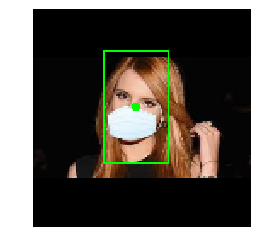

In [205]:
cv2.circle(img, (x, y),1,(0,255,0),2)
cv2.rectangle(img, (x-(w//2), y-(h//2)), ((x-(w//2)) + w, (y-(h//2)) + h), (0, 255, 0), 1)
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [262]:
def resize_img_bbox_letterbox(img, bbox, size):
    
    w,h = img.shape[1], img.shape[0]
    scale = min(size/w, size/h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized_image = cv2.resize(img, (new_w, new_h))
    canvas = np.full((size, size, 3), 0)
    canvas[(size-new_h)//2:(size-new_h)//2 + new_h,(size-new_w)//2:(size-new_w)//2 + new_w,  :] = resized_image
    canvas = canvas.astype(np.uint8)
   
    bbox[:4] = bbox[:4] * scale
    
    # add padding h w
    bbox[:4] += np.array([(size - new_w)/2, (size - new_h)/2, 0, 0]).astype(int)
    
    return canvas, bbox

In [263]:
print(np.array([x,y,w,h,1]))
img , bbox = resize_img_bbox_letterbox(image, np.array([x,y,w,h,1]), 128)
x1, y1, w1, h1, _ = bbox
print(bbox)

[141  69  89  89   1]
[60 57 38 38  1]


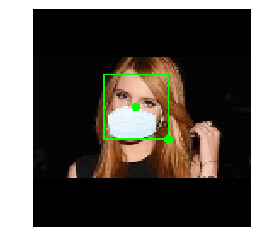

In [264]:
cv2.circle(img, (x1, y1),1,(0,255,0),2)
cv2.circle(img, ((x1-(w1//2)) + w1, (y1-(h1//2)) + h1),1,(0,255,0),2)
cv2.rectangle(img, (x1-(w1//2), y1-(h1//2)), ((x1-(w1//2)) + w1, (y1-(h1//2)) + h1), (0, 255, 0), 1)
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()